### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os
import pdfplumber
import shutil
import glob
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
import math
import random

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

2023-01-31 18:41:55.717068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 18:41:55.717306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids, attention_mask=attention_mask)[0])
    print(np.shape(input_ids))
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        residues = embedding[seq_num][1:seq_len-1]
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
average_embeddings = get_embeddings(sequences_Example)

(2, 9)


In [6]:
tf.__version__

'2.10.0'

# Data Formatting

In [7]:
df = pd.read_csv("../Data/CoV-AbDab_201222.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
0,EVQLVESGGGLIQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLE...
1,EVQLVQSGGGLVQPGGSLRLSCLASGLTFSSYEFNWIRQAPGKGLE...
2,QVQLVQSGAEVKRPGASVKVLCMASGYSFTNYGINWVRQAPGQGLE...
3,EVQLVQSGAEVKKPRESLKISCKGSGYNFTSYWIGWVRQMPGKGLE...
4,EVQLVESGGGLVQPGGSLRLSCAASRFTFANYWMSWVRQAPGKGLE...
...,...
11999,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
12000,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
12001,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
12002,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [8]:
head = []
dummy = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for covid, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 37500:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 37500


In [9]:
# print(healthy_sequences)
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))
print(len(healthy_sequences))
print(len(covid_sequences))
# print(covid_sequences)

138
138
37500
11538


In [10]:
del head
del myfile
del dummy
gc.collect()

0

In [11]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [12]:
if os.path.exists('covid_binary_embeddings') == False:
    os.mkdir('covid_binary_embeddings')

In [13]:
number_param_covid = math.ceil(len(covid_sequences)/3000)

for i in range(number_param_covid):
    covid_sequences_new = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * (1/number_param_covid) * i):round(len(covid_sequences) * (1/number_param_covid) * (i+1))]
    covid_average_embeddings = get_embeddings(covid_sequences_new)

    with open("covid_binary_embeddings/covid_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(covid_average_embeddings, f)

    del covid_sequences_new
    del covid_average_embeddings
    gc.collect()

(2884, 140)
(2885, 140)
(2885, 140)
(2884, 140)


In [14]:
number_param_healthy = math.ceil(len(healthy_sequences)/3000)

for i in range(number_param_healthy):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * (1/number_param_healthy) * i):round(len(healthy_sequences) * (1/number_param_healthy) * (i+1))]
    healthy_average_embeddings = get_embeddings(healthy_sequences_new)

    with open("covid_binary_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(healthy_average_embeddings, f)
    f.close()

    del healthy_sequences_new
    del healthy_average_embeddings
    gc.collect()

(2885, 139)
(2884, 140)
(2885, 137)
(2885, 139)
(2884, 138)
(2885, 138)
(2885, 139)
(2884, 134)
(2885, 137)
(2884, 139)
(2885, 137)


# Loading

In [2]:
covid_average_embeddings = [[None] * 1024]

In [3]:
number_param_covid = 4
for i in range(number_param_covid):
    with open("covid_binary_embeddings/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        covid_average_embeddings = np.concatenate((covid_average_embeddings, covid_temp))
    f.close()

covid_average_embeddings = np.delete(covid_average_embeddings, 0, 0)

In [4]:
healthy_average_embeddings = [[None] * 1024]

In [5]:
number_param_healthy = 13
for i in range(number_param_healthy):
    with open("covid_binary_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [6]:
print(healthy_average_embeddings.shape)

(37500, 1024)


In [7]:
healthy_lables = [0] * 11538 # 37500
covid_lables = [1] * 11538

# Model 3: Averaging Embeddings

In [8]:
X = np.concatenate((healthy_average_embeddings[:11538], covid_average_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [9]:
del covid_average_embeddings
gc.collect()

0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

18691
2308
2077


In [12]:
print(len([i for i in y_test if i == 0]))
print(len([i for i in y_test if i == 1]))
print(len([i for i in y_val if i == 0]))
print(len([i for i in y_val if i == 1]))

1174
1134
1063
1014


In [13]:
# val_set = zip(X_val, y_val)
# new_y_val = []
# new_X_val = []
# count = 0
# for i in val_set:
#     if i[1] == 1:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#     if i[1] == 0 and count < 1005:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#         count+=1

# c = list(zip(new_X_val, new_y_val))

# # random.shuffle(c)

# X_val, y_val = zip(*c)
# y_val = np.array(y_val)
# # print(y_val)

In [14]:
# test_set = zip(X_test, y_test)
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 1175:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# # random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# # print(y_test)

In [15]:
X_train = np.concatenate((X_train, healthy_average_embeddings[11539:41000]))
y_train = np.concatenate((y_train, [0] * len(healthy_average_embeddings[11539:41000])))

In [16]:
for i in y_train:
    print(i)

0
0
0
1
1
1
0
1
0
1
1
1
1
0
0
0
0
1
0
0
0
0
1
1
0
1
0
0
0
1
1
0
1
1
1
1
0
1
1
0
0
0
0
0
0
0
1
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
0
1
1
1
0
1
0
1
0
1
1
1
0
0
0
1
0
1
0
0
0
1
0
1
1
0
1
1
0
1
0
1
0
0
1
0
0
1
1
1
1
1
0
1
0
0
0
1
1
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
0
1
0
0
1
0
1
0
0
1
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
1
0
1
1
1
0
1
1
0
1
0
1
0
0
0
0
1
1
1
1
1
0
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
0
0
0
1
1
1
1
0
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
1
1
0
1
0
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
0
1
1
0
0
0
0
1
0
0
1
1
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
0
0
1
1
0
1
0
0
0
0
0
1
0
1
1
1
0
1
1
1
0
0
1
0
1
1
1
1
1
1
1
0
0
0
1
0
0
1
1
0
1
0
1
1
1
1
0
1
1
1
1
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
0
1
0
0
0
0
1
1
1
1
0
1
1
0
1
0
1
1
1
0
0
1
1
1
0
0
0
0
1
0
0
0
0
1
0
1
0
0
1
0
1
1
1
0
1
0
0
0
1
1
1
1
1
1
1
0
0
1
0
0
1
0
1
0
0
0
1
0
0
1
0
0
1
1
1
1
1
0
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
0
1
1
0
0
1


In [17]:
del healthy_average_embeddings
del X
del y
gc.collect()

0

### Using SMOTE

In [18]:
print(len([i for i in y_train if i == 0]))
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)

In [ ]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

In [ ]:
for i in y_train:
    print(i)

0
0
0
1
1
1
0
1
0
1
1
1
1
0
0
0
0
1
0
0
0
0
1
1
0
1
0
0
0
1
1
0
1
1
1
1
0
1
1
0
0
0
0
0
0
0
1
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
0
1
1
1
0
1
0
1
0
1
1
1
0
0
0
1
0
1
0
0
0
1
0
1
1
0
1
1
0
1
0
1
0
0
1
0
0
1
1
1
1
1
0
1
0
0
0
1
1
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
1
0
1
0
0
1
0
1
0
0
1
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
1
0
1
1
1
0
1
1
0
1
0
1
0
0
0
0
1
1
1
1
1
0
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
0
0
0
1
1
1
1
0
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
1
1
0
1
0
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
0
1
1
0
0
0
0
1
0
0
1
1
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
0
0
1
1
0
1
0
0
0
0
0
1
0
1
1
1
0
1
1
1
0
0
1
0
1
1
1
1
1
1
1
0
0
0
1
0
0
1
1
0
1
0
1
1
1
1
0
1
1
1
1
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
0
1
0
0
0
0
1
1
1
1
0
1
1
0
1
0
1
1
1
0
0
1
1
1
0
0
0
0
1
0
0
0
0
1
0
1
0
0
1
0
1
1
1
0
1
0
0
0
1
1
1
1
1
1
1
0
0
1
0
0
1
0
1
0
0
0
1
0
0
1
0
0
1
1
1
1
1
0
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
0
1
1
0
0
1


In [ ]:
c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
y_train = np.array(y_train)
for i in y_train:
    print(i)

0
1
0
0
1
0
0
1
0
1
0
0
1
1
1
1
1
0
0
1
1
0
0
1
1
0
1
0
1
1
1
1
0
0
0
1
1
1
0
1
0
0
0
0
0
1
0
1
0
0
1
0
1
0
0
1
1
0
0
0
1
0
0
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
1
0
0
1
1
1
1
0
0
1
1
0
0
0
0
0
1
1
1
0
1
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
1
1
0
0
1
0
0
1
0
0
1
1
0
1
0
1
1
1
1
0
0
0
1
0
0
1
1
0
0
1
0
1
0
0
0
1
1
0
1
1
1
0
0
0
1
0
1
1
1
1
1
0
0
1
0
1
1
1
1
1
0
0
1
0
0
0
1
1
0
0
1
0
1
0
0
0
1
0
1
0
1
0
0
0
0
1
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
0
1
1
1
0
1
0
0
0
1
0
0
1
0
0
0
1
0
0
1
0
1
0
0
1
0
0
0
1
1
0
1
0
0
1
1
1
0
1
1
0
0
0
1
1
0
0
0
1
0
0
0
0
0
1
0
0
1
0
1
0
0
1
1
1
1
1
0
1
0
1
1
1
1
1
0
1
1
1
0
0
1
1
0
1
1
1
0
1
0
1
0
1
1
1
0
0
1
1
0
1
1
0
0
0
0
0
0
1
1
1
0
1
0
1
0
1
1
0
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
0
0
1
1
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
1
1
1
1
1
0
1
1
1
1
1
0
1
1
0
0
1
0
1
1
1
0
1
0
1
0
1
1
1
0
1
0
0
1
1
0
1
1
0
1
1
1
0
0
1
0
1
1
0
1
1
1
0
1
1
0
1
0
1
0
1
0
0
1
0
1
0
0
0
1
0
0
0
0
0
1
1
0
1
1
0
0
1
1
0
1
0
0
1
0
1
0
0
1
0
1
1
1
1
1


### Using Borderline SMOTE

In [22]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

### Model Evaluation

In [15]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-31 19:59:44.956313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 19:59:44.956581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                                                 
 dense_4 (Dense)             (None, 256)               9

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [18]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=150,
    mode='auto',
    restore_best_weights=True,
)

In [19]:
history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/1000


2023-01-31 19:59:49.273550: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-31 19:59:49.659916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.7485

2023-01-31 19:59:59.645747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


585/585 [==============================] - 11s 17ms/step - loss: 0.4842 - accuracy: 0.7485 - val_loss: 0.4217 - val_accuracy: 0.7920
Epoch 2/1000
585/585 [==============================] - 11s 18ms/step - loss: 0.4061 - accuracy: 0.7975 - val_loss: 0.3821 - val_accuracy: 0.8026
Epoch 3/1000
585/585 [==============================] - 10s 17ms/step - loss: 0.3779 - accuracy: 0.8124 - val_loss: 0.3729 - val_accuracy: 0.8060
Epoch 4/1000
585/585 [==============================] - 10s 17ms/step - loss: 0.3674 - accuracy: 0.8173 - val_loss: 0.3562 - val_accuracy: 0.8190
Epoch 5/1000
585/585 [==============================] - 10s 17ms/step - loss: 0.3501 - accuracy: 0.8272 - val_loss: 0.3805 - val_accuracy: 0.7920
Epoch 6/1000
585/585 [==============================] - 9s 16ms/step - loss: 0.3462 - accuracy: 0.8331 - val_loss: 0.4196 - val_accuracy: 0.7636
Epoch 7/1000
585/585 [==============================] - 10s 16ms/step - loss: 0.3397 - accuracy: 0.8334 - val_loss: 0.3306 - val_accuracy:

: 

: 

In [32]:
with open('covid_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

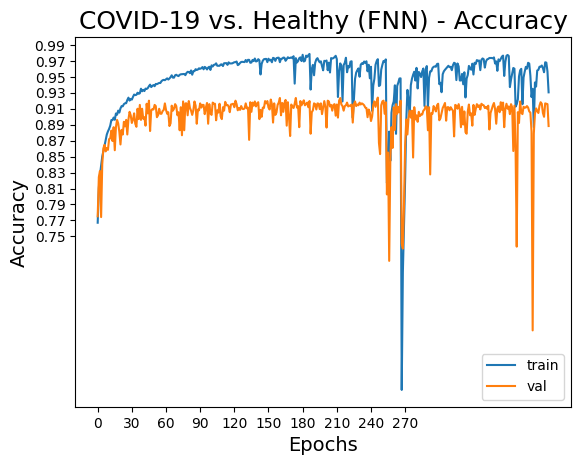

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 1.0, 0.02))
plt.xticks(np.arange(0, 280, 30.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [34]:
model.save("covid_model.h5")

In [28]:
model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 7ms/step - loss: 0.2678 - accuracy: 0.8899


[0.26775994896888733, 0.8899480104446411]

In [36]:
model = tf.keras.models.load_model("covid_model.h5")

In [37]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 14ms/step


2023-01-27 06:36:46.245546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

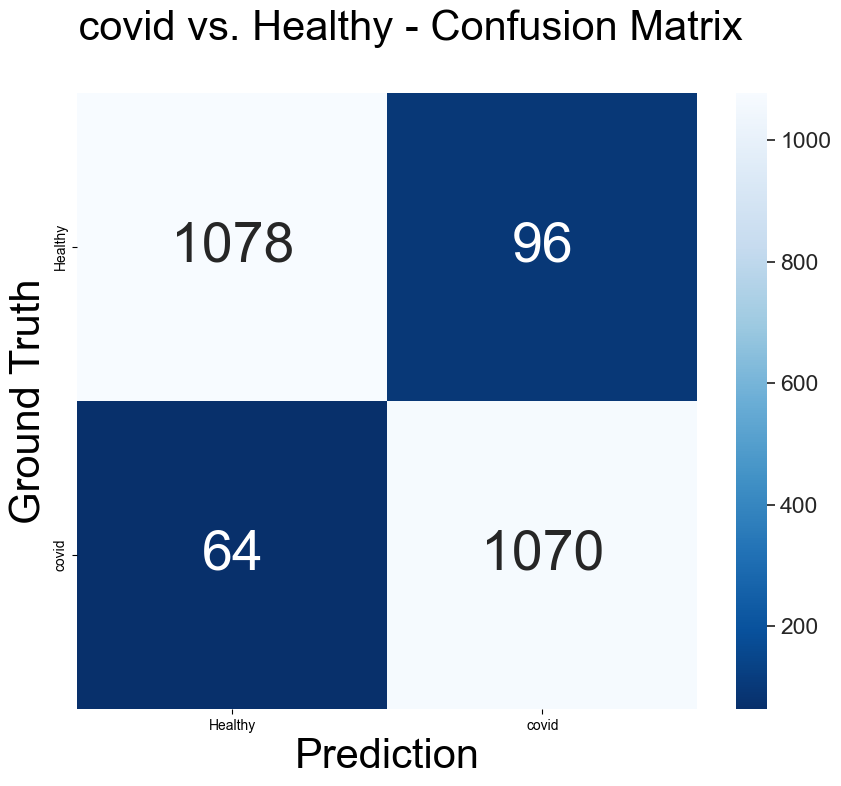

tf.Tensor(
[[1078   96]
 [  64 1070]], shape=(2, 2), dtype=int32)


In [38]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    covid vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "covid"],
            yticklabels=["Healthy", "covid"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [39]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

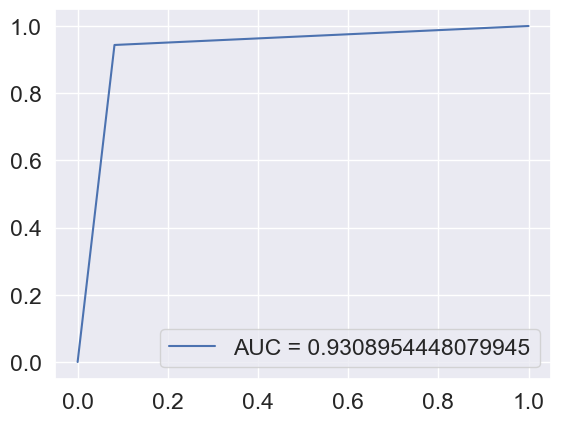

In [40]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()